In [13]:
%matplotlib inline

from __future__ import print_function

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, MaxAbsScaler, minmax_scale, maxabs_scale
from sklearn.metrics import mean_squared_error
import matplotlib
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.optimizers import Nadam

### Coordinates
**straight** - predict each coordinate.

**difference** - ??? (predict differences between neighbour coordinates)


### Amino acid transformations
**one-hot** - code each amino acid as a 20-dimensional vector with 1 at the index of the corresponding amino acid.

**kidera** - worked worse than one-hot.

**atchley** - ???


### Feature generation
**window** - sliding window, predict the coordinate in the centre of the window.

**directional / bidirectional** - ??? (RNN)


### Feature preprocessing
**scale the data**:
Tested on models with [128,64] dense layers, 4-4 window size, 2000 iterations.
- per column - scale each column independently:
```
MSE:
no scale:
    cdr - 1.61775   ***
    can - 0.0993797
MinMax:
    cdr - 2.43089   *
    can - 0.0978544
MaxAbs:
    cdr - 1.95208   **
    can - 0.0967865
```
- overall - scale the overall matrix:
```
no scale:
    cdr - 1.61775   ***
    can - 0.0993797
MinMax:
    cdr - 2.27693   *
    can - 0.105339
MaxAbs:
    cdr - 1.96837   **
    can - 0.0973526
```

**clusterize** - ??? (assign weights accroding to the clusters' sizes)


### Batch generation
**add putative sequences to batches** - ??? (to add noise)


### Post-analysis
**ensembling** - ???

In [2]:
kidera_s = """
A -1.56	-1.67	-0.97	-0.27	-0.93	-0.78	-0.2	-0.08	0.21	-0.48 
R 0.22	1.27	1.37	1.87	-1.7	0.46	0.92	-0.39	0.23	0.93 
N 1.14	-0.07	-0.12	0.81	0.18	0.37	-0.09	1.23	1.1	-1.73 
D 0.58	-0.22	-1.58	0.81	-0.92	0.15	-1.52	0.47	0.76	0.7 
C 0.12	-0.89	0.45	-1.05	-0.71	2.41	1.52	-0.69	1.13	1.1 
Q -0.47	0.24	0.07	1.1	1.1	0.59	0.84	-0.71	-0.03	-2.33 
E -1.45	0.19	-1.61	1.17	-1.31	0.4	0.04	0.38	-0.35	-0.12 
G 1.46	-1.96	-0.23	-0.16	0.1	-0.11	1.32	2.36	-1.66	0.46 
H -0.41	0.52	-0.28	0.28	1.61	1.01	-1.85	0.47	1.13	1.63 
I -0.73	-0.16	1.79	-0.77	-0.54	0.03	-0.83	0.51	0.66	-1.78 
L -1.04	0	-0.24	-1.1	-0.55	-2.05	0.96	-0.76	0.45	0.93 
K -0.34	0.82	-0.23	1.7	1.54	-1.62	1.15	-0.08	-0.48	0.6 
M -1.4	0.18	-0.42	-0.73	2	1.52	0.26	0.11	-1.27	0.27 
F -0.21	0.98	-0.36	-1.43	0.22	-0.81	0.67	1.1	1.71	-0.44 
P 2.06	-0.33	-1.15	-0.75	0.88	-0.45	0.3	-2.3	0.74	-0.28 
S 0.81	-1.08	0.16	0.42	-0.21	-0.43	-1.89	-1.15	-0.97	-0.23 
T 0.26	-0.7	1.21	0.63	-0.1	0.21	0.24	-1.15	-0.56	0.19 
W 0.3	2.1	-0.72	-1.57	-1.16	0.57	-0.48	-0.4	-2.3	-0.6 
Y 1.38	1.48	0.8	-0.56	0	-0.68	-0.31	1.03	-0.05	0.53 
V -0.74	-0.71	2.04	-0.4	0.5	-0.81	-1.07	0.06	-0.46	0.65
""".split("\n")

In [3]:
# coord = "x"
# df_cdr = pd.read_csv("data/cdr_coord_" + coord + ".csv.gz")
# df_put = pd.read_csv("data/put_coord_" + coord + ".csv.gz")
# df_can = pd.read_csv("data/can_coord_" + coord + ".csv.gz")

# print(df_cdr.shape)
# print(df_put.shape)
# print(df_can.shape)

# df_can.head()

In [4]:
MAX_POS=12

chars = ["A", "L", "R", 'K', 'N', 'M', 'D', 'F', 'C', 'P', 'Q', 'S', 'E', 'T', 'G', 'W', 'H', 'Y', 'I', 'V']
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

one_hot = dict((c, np.zeros((len(chars),), dtype=bool)) for c in chars)
for c in one_hot:
    one_hot[c][char_indices[c]] = 1
    
kidera = {}
for ls in list(map(lambda x: x.split(), kidera_s)):
    if ls:
        kidera[ls[0]] = np.array(ls[1:], dtype=np.float32)


# def to_vec_kidera(df, left_window, right_window):
#     X = np.zeros((len(df)*MAX_POS, (left_window+right_window+1) * 10), dtype=bool)
#     y = np.zeros((len(df)*MAX_POS, 1), dtype=np.float32)
#     for seq_i, seq in enumerate(df["sequence"]):
#         seq = "X"*left_window + seq + "X"*right_window
#         for index, target_pos in enumerate(range(left_window + 1, len(seq) - right_window)):
#             target_aa = seq[target_pos]
#             for amb_pos, amb_aa in enumerate(seq[target_pos-left_window : target_pos+right_window+1]):
#                 if amb_aa != "X":
#                     X[seq_i*MAX_POS + index, amb_pos*10:(amb_pos+1)*10] = kidera[amb_aa]
#             y[seq_i*MAX_POS + index] = df[[4 + index]].iloc[seq_i]
#     return X, y

# X_can, y_can = to_vec_onehot(df_can, 5, 5)
# print(X_can.shape)
# # X_put, y_put = to_vec_onehot(df_put, 3, 3)
# # print(X_put.shape)
# X_cdr, y_cdr = to_vec_onehot(df_cdr, 5, 5)
# print(X_cdr.shape)

In [26]:
def add_dense(model, h_units):
    model.add(Dense(h_units))
    model.add(BatchNormalization())
    model.add(PReLU())
    model.add(Dropout(.3))
    
#     Problems here:
#     model.add(Dropout(.3))
#     model.add(BatchNormalization())
#     model.add(PReLU())

              
def dense_model(shape, output, h_units = [256, 128, 64]):
    model = Sequential()
    
    model.add(Dense(h_units[0], input_shape=shape))
    model.add(BatchNormalization())
    model.add(PReLU())
    model.add(Dropout(.3))
    
    for num in h_units[1:]:
        add_dense(model, num)
        
    model.add(Dense(output))
    model.add(PReLU())
    
#     opt = Nadam(lr=0.002)
    opt = Nadam(lr=0.0007)
    model.compile(optimizer=opt, loss="mse")
    
    return model

# 1-dimensional models

In [6]:
# Predicted and real coordinates
def plot_pred(df, pred, ax, title):
    trans = pred.reshape((len(df),12))
    for i in range(len(df)):
        ax.plot(range(12), df.iloc[i,4:16], c="black", alpha=.5, label="real")
        ax.plot(range(12), trans[i,:], c = "red", linestyle="dotted", alpha=.8, label="pred")
    ax.set_title(title)

def plot_all_pred(model, savepath):
    df_cdr = pd.read_csv("data/cdr_coord_x.csv.gz")
    df_can = pd.read_csv("data/can_coord_x.csv.gz")
    X_cdr, y_cdr = to_vec_onehot(df_cdr, 4, 4)
    X_can, y_can = to_vec_onehot(df_can, 4, 4)

    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_figwidth(16)
#     fig.set_figwidth(10)

    pred = m_no.predict(X_cdr)
    # _, pred = get_true_pred("data/cdr_coord_x.csv.gz", MinMaxScaler(), m_mm)
    # _, pred = get_true_pred("data/cdr_coord_x.csv.gz", MaxAbsScaler(), m_abs)
    plot_pred(df_cdr, pred, ax[0], "CDR")

    pred = m_no.predict(X_can)
    # _, pred = get_true_pred("data/can_coord_x.csv.gz", MinMaxScaler(), m_mm)
    # _, pred = get_true_pred("data/can_coord_x.csv.gz", MaxAbsScaler(), m_abs)
    plot_pred(df_can, pred, ax[1], "Canonical")
    
    if savepath: plt.savefig(savepath)

In [27]:
def to_vec_onehot(df, left_window, right_window):
    X = np.zeros((len(df)*MAX_POS, (left_window+right_window+1) * len(chars)), dtype=bool)
    y = np.zeros((len(df)*MAX_POS, 1), dtype=np.float32)
    for seq_i, seq in enumerate(df["sequence"]):
        seq = "X"*left_window + seq + "X"*right_window
        for index, target_pos in enumerate(range(left_window + 1, len(seq) - right_window)):
            target_aa = seq[target_pos]
            for amb_pos, amb_aa in enumerate(seq[target_pos-left_window : target_pos+right_window+1]):
                if amb_aa != "X":
                    X[seq_i*MAX_POS + index, amb_pos*len(chars):(amb_pos+1)*len(chars)] = one_hot[amb_aa]
            y[seq_i*MAX_POS + index] = df[[4 + index]].iloc[seq_i]
    return X, y


def train_models(coord, layers, left_window, right_window, n_epochs, hist):
    model_name = "left" + str(left_window) + "_right" + str(right_window) + "." + "-".join(map(str, layers))
    if model_name not in hist:
        print(model_name)
        df_cdr = pd.read_csv("data/cdr_coord_" + coord + ".csv.gz")
        df_can = pd.read_csv("data/can_coord_" + coord + ".csv.gz")

        X_can, y_can = to_vec_onehot(df_can, left_window, right_window)
        X_cdr, y_cdr = to_vec_onehot(df_cdr, left_window, right_window)

        model = dense_model((20*(right_window+left_window+1),), 1, layers)

        hist[model_name] = model.fit(X_can, y_can, batch_size=64, epochs=n_epochs, verbose=0, validation_data=(X_cdr, y_cdr))
        
        return model

        
def train_models_scale_col(coord, layers, left_window, right_window, n_epochs, hist, scale):
    model_name = "left" + str(left_window) + "_right" + str(right_window) + "." + "-".join(map(str, layers)) + "_col_" + scale
    if model_name not in hist:
        print(model_name)
        df_cdr = pd.read_csv("data/cdr_coord_" + coord + ".csv.gz")
        df_can = pd.read_csv("data/can_coord_" + coord + ".csv.gz")
        
        for i in range(4, 16):
            if scale == "mm":
                df_cdr.iloc[:,i] = minmax_scale(df_cdr.iloc[:,i])
                df_can.iloc[:,i] = minmax_scale(df_can.iloc[:,i])
            else:
                df_cdr.iloc[:,i] = maxabs_scale(df_cdr.iloc[:,i])
                df_can.iloc[:,i] = maxabs_scale(df_can.iloc[:,i])

        X_can, y_can = to_vec_onehot(df_can, left_window, right_window)
        X_cdr, y_cdr = to_vec_onehot(df_cdr, left_window, right_window)

        model = dense_model((20*(right_window+left_window+1),), 1, layers)

        hist[model_name] = model.fit(X_can, y_can, batch_size=64, epochs=n_epochs, verbose=0, validation_data=(X_cdr, y_cdr))
        
        return model

    
def train_models_scale_all(coord, layers, left_window, right_window, n_epochs, hist, scale):
    model_name = "left" + str(left_window) + "_right" + str(right_window) + "." + "-".join(map(str, layers)) + "_all_" + scale
    if model_name not in hist:
        print(model_name)
        df_cdr = pd.read_csv("data/cdr_coord_" + coord + ".csv.gz")
        df_can = pd.read_csv("data/can_coord_" + coord + ".csv.gz")

        if scale == "mm":
            df_cdr.iloc[:,range(4, 16)] = minmax_scale(df_cdr.iloc[:,range(4, 16)])
            df_can.iloc[:,range(4, 16)] = minmax_scale(df_can.iloc[:,range(4, 16)])
        else:
            df_cdr.iloc[:,range(4, 16)] = maxabs_scale(df_cdr.iloc[:,range(4, 16)])
            df_can.iloc[:,range(4, 16)] = maxabs_scale(df_can.iloc[:,range(4, 16)])

        X_can, y_can = to_vec_onehot(df_can, left_window, right_window)
        X_cdr, y_cdr = to_vec_onehot(df_cdr, left_window, right_window)

        model = dense_model((20*(right_window+left_window+1),), 1, layers)

        hist[model_name] = model.fit(X_can, y_can, batch_size=64, epochs=n_epochs, verbose=0, validation_data=(X_cdr, y_cdr))
        
        return model


## Check if scaling works better than no-transformation

### Per-column scaling

In [34]:
hist_scale.pop("left6_right6.128-64-64_col_abs")

In [35]:
# hist_scale = {}
# m_0 = train_models("x", [128,64], 4, 4, 3000, hist_scale)
m_1 = train_models_scale_col("x", [128,64,64], 6, 6, 3000, hist_scale, "abs")
# m_abs_col = train_models_scale_col("x", [128,64], 4, 4, 2000, hist_scale, "abs")

left6_right6.128-64-64_col_abs


In [36]:
scalers = {"mm": {"cdr":[], "can":[]}, "abs": {"cdr": [], "can":[]} }

def get_true_pred_col(filepath, scaler, model, l, r):
    df = pd.read_csv(filepath)
    sc_ls = []
    
    for i in range(4, 16):
        sc = scaler()
        df.iloc[:,i] = sc.fit_transform(df.iloc[:,i].values.reshape(-1, 1))
        sc_ls.append(sc)
    
    X, y = to_vec_onehot(df, l, r)

    y_tr = y.reshape((len(df), 12))
    for sc_i, i in enumerate(range(4, 16)):
        y_tr[:,sc_i] = sc_ls[sc_i].inverse_transform(y_tr[:,sc_i])
    y_tr = y_tr.reshape((X.shape[0],))
    
    y_pred = model.predict(X)
    y_pred = y_pred.reshape((len(df), 12))
    for sc_i, i in enumerate(range(4, 16)):
        y_pred[:,sc_i] = sc_ls[sc_i].inverse_transform(y_pred[:,sc_i])
    y_pred = y_pred.reshape((X.shape[0],))
    
    return y_tr, y_pred


def tr_pred_col(filepath, scaler, model, l, r):
    y_tr, y_pr = get_true_pred_col(filepath, scaler, model, l, r)
    return mean_squared_error(y_tr, y_pr)


df_cdr = pd.read_csv("data/cdr_coord_x.csv.gz")
df_can = pd.read_csv("data/can_coord_x.csv.gz")
X_cdr, y_cdr = to_vec_onehot(df_cdr, 4, 4)
X_can, y_can = to_vec_onehot(df_can, 4, 4)
print("cdr", mean_squared_error(y_cdr, m_0.predict(X_cdr)))
print("can", mean_squared_error(y_can, m_0.predict(X_can)))

# print("cdr", tr_pred_col("data/cdr_coord_x.csv.gz", MinMaxScaler, m_mm_col, 4, 4))
# print("can", tr_pred_col("data/can_coord_x.csv.gz", MinMaxScaler, m_mm_col, 4, 4))

print("cdr", tr_pred_col("data/cdr_coord_x.csv.gz", MaxAbsScaler, m_1, 6, 6))
print("can", tr_pred_col("data/can_coord_x.csv.gz", MaxAbsScaler, m_1, 6, 6))

# cdr 1.61775
# can 0.0993797
# cdr 2.43089
# can 0.0978544
# cdr 1.95208
# can 0.0967865

# batch=128
# cdr 1.79415
# can 0.117869
# cdr 2.08438
# can 0.118282

# batch=64
# cdr 1.47792
# can 0.113192
# cdr 2.42609
# can 0.127746

# batch=64, lr=0.0007
# cdr 1.63911
# can 0.0998089
# cdr 1.85481
# can 0.103108

cdr 1.63911
can 0.0998089


/home/vdn/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:838: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vdn/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:838: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vdn/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:838: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data h

cdr 1.85481
can 0.103108


/home/vdn/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:838: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vdn/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:838: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/vdn/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:838: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data h

## Overall scaling

In [96]:
# hist_scale = {}
# m_no = train_models("x", [128,64], 4, 4, 2000, hist_scale)
# m_mm_all = train_models_scale_all("x", [128,64], 4, 4, 2000, hist_scale, "mm")
# m_abs_all = train_models_scale_all("x", [128,64], 4, 4, 2000, hist_scale, "abs")

left4_right4.128-64_all_mm
left4_right4.128-64_all_abs


In [105]:
def get_true_pred_all(filepath, scaler, model):
    df = pd.read_csv(filepath)
    df.iloc[:,range(4, 16)] = scaler.fit_transform(df.iloc[:,range(4, 16)])
    X, y = to_vec_onehot(df, 4, 4)

    y_tr = y.reshape((len(df), 12))
    y_tr = scaler.inverse_transform(y_tr)
    y_tr = y_tr.reshape((X.shape[0],))
    
    y_pred = model.predict(X)
    y_pred = y_pred.reshape((len(df), 12))
    y_pred = scaler.inverse_transform(y_pred)
    y_pred = y_pred.reshape((X.shape[0],))
    
    return y_tr, y_pred


def tr_pred_all(filepath, scaler, model):
    y_tr, y_pr = get_true_pred_all(filepath, scaler, model)
    return mean_squared_error(y_tr, y_pr)



df_cdr = pd.read_csv("data/cdr_coord_x.csv.gz")
df_can = pd.read_csv("data/can_coord_x.csv.gz")
X_cdr, y_cdr = to_vec_onehot(df_cdr, 4, 4)
X_can, y_can = to_vec_onehot(df_can, 4, 4)
print("cdr", mean_squared_error(y_cdr, m_no.predict(X_cdr)))
print("can", mean_squared_error(y_can, m_no.predict(X_can)))

print("cdr", tr_pred("data/cdr_coord_x.csv.gz", MinMaxScaler(), m_mm_all))
print("can", tr_pred("data/can_coord_x.csv.gz", MinMaxScaler(), m_mm_all))

print("cdr", tr_pred("data/cdr_coord_x.csv.gz", MaxAbsScaler(), m_abs_all))
print("can", tr_pred("data/can_coord_x.csv.gz", MaxAbsScaler(), m_abs_all))


# cdr 1.61775
# can 0.0993797
# cdr 2.27693
# can 0.105339
# cdr 1.96837
# can 0.0973526

cdr 1.61775
can 0.0993797
cdr 2.27693
can 0.105339
cdr 1.96837
can 0.0973526


## Find which windows and layer sizes are the best

In [21]:
# best_models = [(3,3), (4,4), (5,5), (6,6)]
# best_layers = [[64, 64, 64], [128, 64], [128, 64, 64], [256, 128], [256, 128, 64]]

# best_models = [(3,3), (4,4)]
# best_layers = [[16, 16, 16], [32, 16]]

# best_models = [(4,4)]
# best_layers = [[128, 64]]
# best_hist = {}
# for l,r in best_models:
#     for layers in best_layers:
#         train_models("x", layers, l, r, 3000, best_hist)
        
best_models = [(6,6)]
best_layers = [[128, 64, 64], [256,128]]
best_hist_scale = {}
for l,r in best_models:
    for layers in best_layers:
#         train_models_scale_col("x", layers, l, r, 3000, best_hist_scale, "mm")
        train_models_scale_col("x", layers, l, r, 3000, best_hist_scale, "abs")
#         train_models_scale_all("x", layers, l, r, 3000, best_hist_scale, "mm")
#         train_models_scale_all("x", layers, l, r, 3000, best_hist_scale, "abs")

left6_right6.128-64-64_col_abs
left6_right6.256-128_col_abs


# Visualize loss

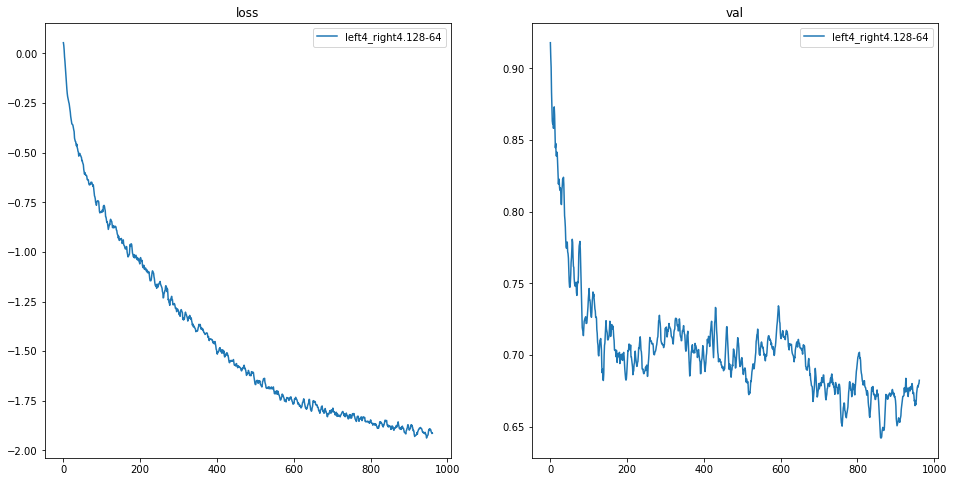

In [22]:
fig, ax = plt.subplots(nrows=1, sharex=True, ncols=2)
fig.set_figwidth(16)
fig.set_figheight(8)

def smooth(vec):
    res = []
    window = 8
    step = 3
    for i in range(window, len(vec)-window, step):
        res.append(np.mean(vec[i-window:i+window+1]))
    return res

cur_hist = best_hist
best_models = sorted([(h, np.mean(cur_hist[h].history["val_loss"][-5:])) for h in cur_hist], key=lambda x: x[1])[:10]

# for i, h in enumerate(sorted(cur_hist.keys())):
for i, (h, _) in enumerate(best_models):
    ax[0].plot(np.log2(smooth(cur_hist[h].history["loss"][100:])), label=h)
    ax[1].plot(np.log2(smooth(cur_hist[h].history["val_loss"][100:])), label=h)


ax[0].set_title("loss")
ax[1].set_title("val")
ax[0].legend()
ax[1].legend()

plt.savefig("loss_dense_onehot_noscale_batch64_search_top10_lr2.png")

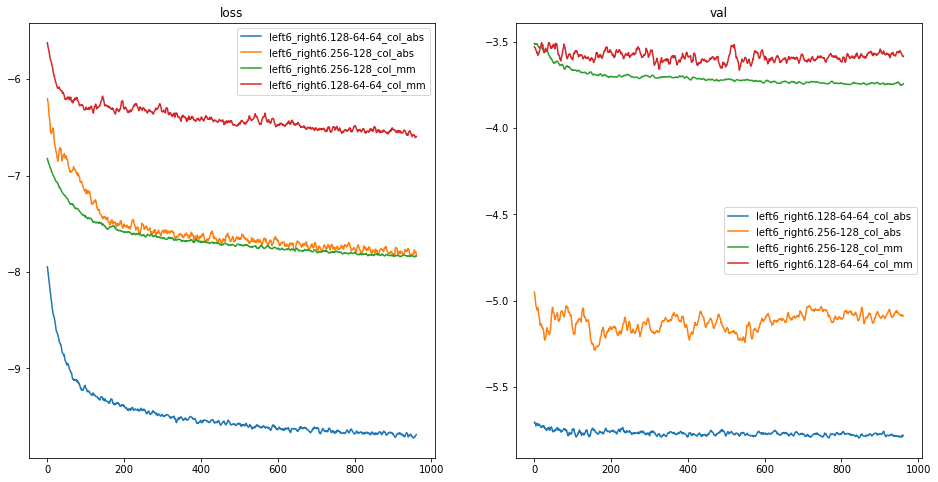

In [23]:
fig, ax = plt.subplots(nrows=1, sharex=True, ncols=2)
fig.set_figwidth(16)
fig.set_figheight(8)


cur_hist = best_hist_scale
best_models = sorted([(h, np.mean(cur_hist[h].history["val_loss"][-5:])) for h in cur_hist], key=lambda x: x[1])[:10]

# for i, h in enumerate(sorted(cur_hist.keys())):
for i, (h, _) in enumerate(best_models):
    ax[0].plot(np.log2(smooth(cur_hist[h].history["loss"][100:])), label=h)
    ax[1].plot(np.log2(smooth(cur_hist[h].history["val_loss"][100:])), label=h)


ax[0].set_title("loss")
ax[1].set_title("val")
ax[0].legend()
ax[1].legend()

plt.savefig("loss_dense_onehot_scale_batch64_search_top10_lr2.png")

# Visualize predictions

In [ ]:
# Predicted and real coordinates
df_cdr = pd.read_csv("data/cdr_coord_x.csv.gz")
df_can = pd.read_csv("data/can_coord_x.csv.gz")
X_cdr, y_cdr = to_vec_onehot(df_cdr, 4, 4)
X_can, y_can = to_vec_onehot(df_can, 4, 4)

fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_figwidth(16)

pred = m_no.predict(X_cdr)
# _, pred = get_true_pred_col("data/cdr_coord_x.csv.gz", MinMaxScaler, m_mm_col)
# _, pred = get_true_pred_col("data/cdr_coord_x.csv.gz", MaxAbsScaler, m_abs_col)
# _, pred = get_true_pred_all("data/cdr_coord_x.csv.gz", MinMaxScaler(), m_mm_all)
_, pred = get_true_pred_all("data/cdr_coord_x.csv.gz", MaxAbsScaler(), m_abs_all)
plot_pred(df_cdr, pred, ax[0], "CDR")

pred = m_no.predict(X_can)
# _, pred = get_true_pred_col("data/can_coord_x.csv.gz", MinMaxScaler, m_mm_col)
# _, pred = get_true_pred_col("data/can_coord_x.csv.gz", MaxAbsScaler, m_abs_col)
# _, pred = get_true_pred_all("data/can_coord_x.csv.gz", MinMaxScaler(), m_mm_all)
_, pred = get_true_pred_all("data/can_coord_x.csv.gz", MaxAbsScaler(), m_abs_all)
plot_pred(df_can, pred, ax[1], "Canonical")

# plt.savefig("pred_dense_onehot_no.png")
# plt.savefig("pred_dense_onehot_mm_col.png")
# plt.savefig("pred_dense_onehot_mm_all.png")
# plt.savefig("pred_dense_onehot_abs_col.png")
plt.savefig("pred_dense_onehot_abs_all.png")

# 2-dimensional models

In [112]:
def to_vec_onehot(df, df_add, left_window, right_window):
    X = np.zeros((len(df)*MAX_POS, (left_window+right_window+1) * len(chars)), dtype=bool)
    y = np.zeros((len(df)*MAX_POS, 2), dtype=np.float32)
    for seq_i, seq in enumerate(df["sequence"]):
        seq = "X"*left_window + seq + "X"*right_window
        for index, target_pos in enumerate(range(left_window + 1, len(seq) - right_window)):
            target_aa = seq[target_pos]
            for amb_pos, amb_aa in enumerate(seq[target_pos-left_window : target_pos+right_window+1]):
                if amb_aa != "X":
                    X[seq_i*MAX_POS + index, amb_pos*len(chars):(amb_pos+1)*len(chars)] = one_hot[amb_aa]
            y[seq_i*MAX_POS + index, 0] = df[[4 + index]].iloc[seq_i]
            y[seq_i*MAX_POS + index, 1] = df_add[[4 + index]].iloc[seq_i]
    return X, y


def train_models(coord, layers, left_window, right_window, n_epochs, hist):
    model_name = "left" + str(left_window) + "_right" + str(right_window)
    if model_name not in hist:
        df_cdr = pd.read_csv("data/cdr_coord_" + coord[0] + ".csv.gz")
        df_can = pd.read_csv("data/can_coord_" + coord[0] + ".csv.gz")
        
        df_cdr_add = pd.read_csv("data/cdr_coord_" + coord[1] + ".csv.gz")
        df_can_add = pd.read_csv("data/can_coord_" + coord[1] + ".csv.gz")

        X_can, y_can = to_vec_onehot(df_can, df_can_add, left_window, right_window)
        X_cdr, y_cdr = to_vec_onehot(df_cdr, df_cdr_add, left_window, right_window)

        model = dense_model((20*(right_window+left_window+1),), 2, layers)

        hist[model_name] = model.fit(X_can, y_can, batch_size=128, epochs=n_epochs, verbose=0, validation_data=(X_cdr, y_cdr))


# hist = {}
# for left_window in range(8):
#     for right_window in range(8):
#         train_models("x", left_window, right_window, 2000, hist)

In [113]:
best_models = [(3,3), (4,4), (5,5), (6,6)]

best_hist = {}
for l,r in best_models:
    train_models(["x", "y"], [128,64], l, r, 2000, best_hist)

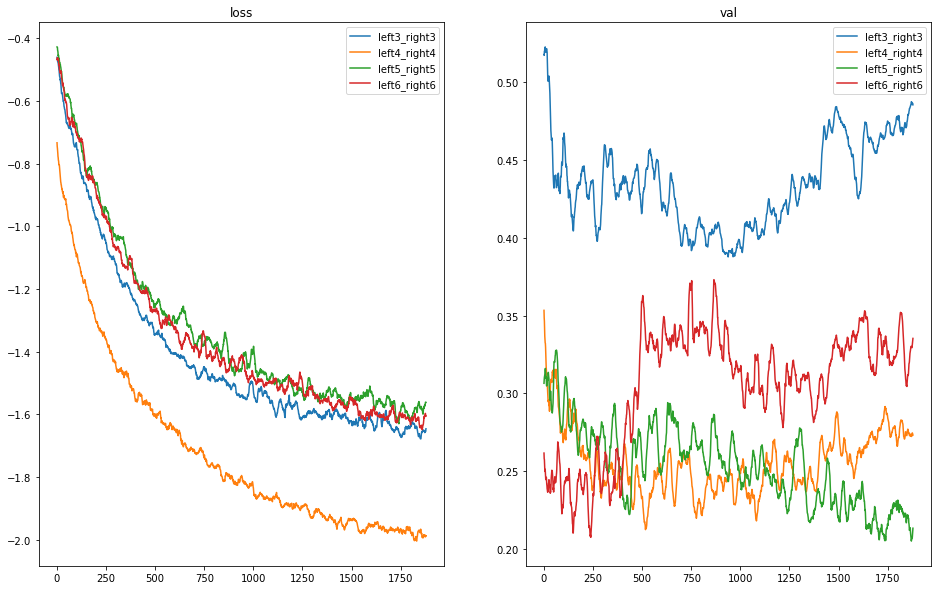

In [114]:
fig, ax = plt.subplots(nrows=1, sharex=True, ncols=2)
fig.set_figwidth(16)
fig.set_figheight(10)

def smooth(vec):
    res = []
    window = 10
    step = 1
    for i in range(window, len(vec)-window, step):
        res.append(np.mean(vec[i-window:i+window+1]))
    return res

cur_hist = best_hist
best_models = sorted([(h, np.mean(cur_hist[h].history["val_loss"][-5:])) for h in cur_hist], key=lambda x: x[1])[:8]

for i, (h, _) in enumerate(sorted(best_models)):
    ax[0].plot(np.log2(smooth(cur_hist[h].history["loss"][100:])), label=h)
    ax[1].plot(np.log2(smooth(cur_hist[h].history["val_loss"][100:])), label=h)


ax[0].set_title("loss")
ax[1].set_title("val")
ax[0].legend()
ax[1].legend()

plt.savefig("loss_xy_dense2layer_onehot_2000it.png")

In [115]:
def to_vec_onehot(df, df_add, left_window, right_window):
    X = np.zeros((len(df)*MAX_POS, (left_window+right_window+1) * len(chars)), dtype=bool)
    y = np.zeros((len(df)*MAX_POS, 2), dtype=np.float32)
    for seq_i, seq in enumerate(df["sequence"]):
        seq = "X"*left_window + seq + "X"*right_window
        for index, target_pos in enumerate(range(left_window + 1, len(seq) - right_window)):
            target_aa = seq[target_pos]
            for amb_pos, amb_aa in enumerate(seq[target_pos-left_window : target_pos+right_window+1]):
                if amb_aa != "X":
                    X[seq_i*MAX_POS + index, amb_pos*len(chars):(amb_pos+1)*len(chars)] = one_hot[amb_aa]
            y[seq_i*MAX_POS + index, 0] = df[[4 + index]].iloc[seq_i]
            y[seq_i*MAX_POS + index, 1] = df_add[[4 + index]].iloc[seq_i]
    return X, y


df_cdr = pd.read_csv("data/cdr_coord_x.csv.gz")
df_can = pd.read_csv("data/can_coord_x.csv.gz")

df_cdr_add = pd.read_csv("data/cdr_coord_y.csv.gz")
df_can_add = pd.read_csv("data/can_coord_y.csv.gz")

X_can, y_can = to_vec_onehot(df_can, df_can_add, 5, 5)
X_cdr, y_cdr = to_vec_onehot(df_cdr, df_cdr_add, 5, 5)

model = dense_model((20*(5+5+1),), 2, [128, 64])

model.fit(X_can, y_can, batch_size=128, epochs=2000, verbose=0, validation_data=(X_cdr, y_cdr))

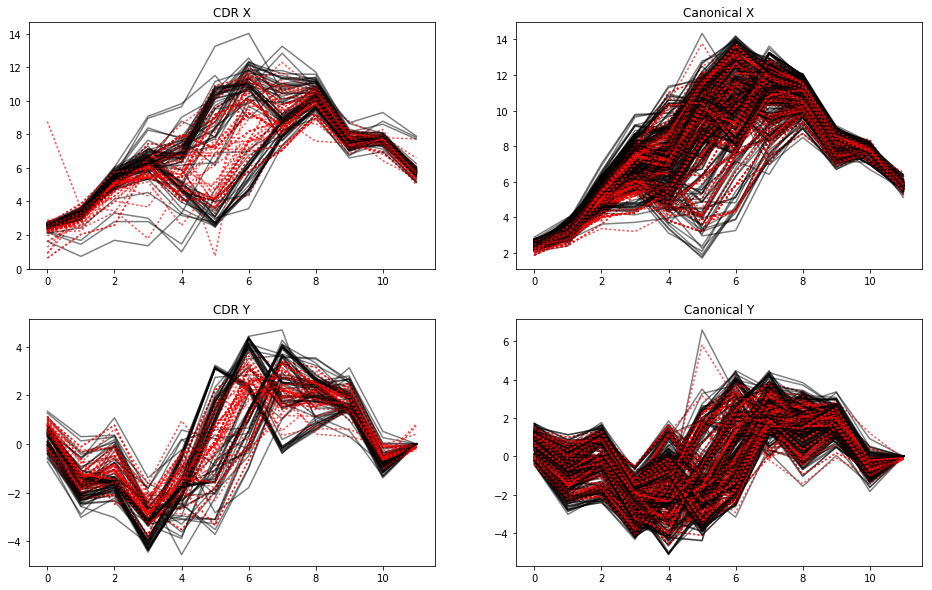

In [119]:
# Predicted and real coordinates
fig, ax = plt.subplots(nrows=2, ncols=2)
fig.set_figwidth(16)
fig.set_figheight(10)


pred = model.predict(X_cdr)
pred_x, pred_y = pred[:,0], pred[:,1]

df_cdr = pd.read_csv("data/cdr_coord_x.csv.gz")
trans = pred_x.reshape((len(df_cdr),12))
for i in range(len(df_cdr)):
    ax[0][0].plot(range(12), df_cdr.iloc[i,4:16], c="black", alpha=.5, label="real")
    ax[0][0].plot(trans[i,:], c = "red", linestyle="dotted", alpha=.7, label="pred")
ax[0][0].set_title("CDR X")

df_cdr = pd.read_csv("data/cdr_coord_y.csv.gz")
trans = pred_y.reshape((len(df_cdr),12))
for i in range(len(df_cdr)):
    ax[1][0].plot(range(12), df_cdr.iloc[i,4:16], c="black", alpha=.5, label="real")
    ax[1][0].plot(trans[i,:], c = "red", linestyle="dotted", alpha=.7, label="pred")
ax[1][0].set_title("CDR Y")

    
pred = model.predict(X_can)
pred_x, pred_y = pred[:,0], pred[:,1]

df_can = pd.read_csv("data/can_coord_x.csv.gz")
trans = pred_x.reshape((len(df_can),12))
for i in range(len(df_can)):
    ax[0][1].plot(range(12), df_can.iloc[i,4:16], c="black", alpha=.5, label="real")
    ax[0][1].plot(trans[i,:], c = "red", linestyle="dotted", alpha=.7, label="pred")
ax[0][1].set_title("Canonical X")

df_can = pd.read_csv("data/can_coord_y.csv.gz")
trans = pred_y.reshape((len(df_can),12))
for i in range(len(df_can)):
    ax[1][1].plot(range(12), df_can.iloc[i,4:16], c="black", alpha=.5, label="real")
    ax[1][1].plot(trans[i,:], c = "red", linestyle="dotted", alpha=.7, label="pred")
ax[1][1].set_title("Canonical Y")

plt.savefig("pred_xy_dense2layer_onehot_2000it.png")

In [140]:
pred = model.predict(X_cdr)
pred_x, pred_y = pred[:,0], pred[:,1]
pred_x[11]

1.6212753